In [8]:
#!/usr/bin/env python3
# code to replicate the performance of the NIPS'16 MLHC workshop paper "Cam CNNS predict anatomy?"

from __future__ import absolute_import
from __future__ import print_function

import os
import csv
import six

import numpy as np
import time
import json
import warnings

from collections import deque
from collections import OrderedDict
from collections import Iterable

# os.environ["THEANO_FLAGS"] = "device=gpu0,floatX=float32" 

os.environ['KERAS_BACKEND'] = 'tensorflow'
# os.environ[
#     "THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32,force_device=true"#,lib.cnmem=0.7 ,nvcc.flags=-D_FORCE_INLINES"
import sys
import numpy as np
from keras import backend as K
K.set_image_data_format('channels_first')
#from keras.datasets import cifar10
#keras.callbacks.Callback()
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Convolution2D, MaxPooling2D 
from keras.layers import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint, Callback
from keras.models import load_model
from keras.datasets import mnist
from scipy import io
from IPython.core.debugger import Tracer
import matplotlib.pyplot as plt


def load_data():
    data = np.load('/work/vsankar/Project-Luna/Train_nf_2_4_rotated_data.npz')
    X_train = data['X_train']
    Y_train = data['Y_train']
    
    data = np.load('/work/vsankar/Project-Luna/Test_nf_2_4_rotated_data.npz')
    X_test = data['X_test']
    Y_test = data['Y_test']    
    
    data = np.load('/work/vsankar/Project-Luna/Val_nf_2_4_rotated_data.npz')
    X_val = data['X_val']
    Y_val = data['Y_val']
    
    return X_train,Y_train,X_test,Y_test,X_val,Y_val

                    
def model_architecture(img_rows,img_cols,img_channels,nb_classes):
    #function defining the architecture of defined CNN
    
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same',init='orthogonal', bias = True, input_shape=(img_channels,img_rows, img_cols)))

    model.add(BN(axis=1, momentum=0.99, epsilon=0.001))
    Dropout((0.25))

    model.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same',init='orthogonal', bias = True))

    model.add(BN(axis=1, momentum=0.99, epsilon=0.00001))
    Dropout((0.25))

    model.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same',init='orthogonal', bias = True))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))
    model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same',init='orthogonal', bias = True))

    model.add(BN(axis=1, momentum=0.99, epsilon=0.001))
    Dropout((0.25))

    model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same',init='orthogonal', bias = True))

    model.add(BN(axis=1, momentum=0.99, epsilon=0.001))
    Dropout((0.25))

    model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same',init='orthogonal', bias = True))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))
    model.add(Convolution2D(96, 3, 3, activation='relu', border_mode='same',init='orthogonal', bias = True))

    model.add(BN(axis=1, momentum=0.99, epsilon=0.001))
    Dropout((0.25))

    model.add(Convolution2D(96, 3, 3, activation='relu', border_mode='same',init='orthogonal', bias = True))

    model.add(BN(axis=1, momentum=0.99, epsilon=0.001))
    Dropout((0.25))

    model.add(Convolution2D(96, 3, 3, activation='relu', border_mode='same',init='orthogonal', bias = True))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))
    model.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same',init='orthogonal', bias = True))

    model.add(BN(axis=1, momentum=0.99, epsilon=0.001))
    Dropout((0.5))

    model.add(Convolution2D(512, 1, 1, activation='relu', border_mode='same',init='orthogonal', bias = True))
    
    model.add(BN(axis=1, momentum=0.99, epsilon=0.001))
    Dropout((0.5))

    model.add(Convolution2D(2, 1, 1, activation='relu', border_mode='same',init='orthogonal', bias = True))
    model.add(GlobalAveragePooling2D(dim_ordering='default'))

    model.add(Activation('softmax'))
    model.summary()
    return model


def normalize_date(X_train,Y_train,X_test,Y_test,X_val, Y_val,nb_classes):
    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')
    print(X_val.shape[0], 'val samples')
    
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_val = X_val.astype('float32')
    
    Y_train = Y_train.astype('float32')
    Y_test = Y_test.astype('float32')
    Y_val = Y_val.astype('float32')

#     normalizing the data
    X_train /= 4095.0   
    X_test /= 4095.0
    X_val /= 4095.0
    
    #std
#     X_train = X_train/np.std(X_train) - np.mean(X_train)
#     X_test = X_test/np.std(X_test) - np.mean(X_test)
    
#     Tracer()()
    # convert class vectors to binary class matrices
    Y_train = np_utils.to_categorical(Y_train, nb_classes)
    Y_test = np_utils.to_categorical(Y_test, nb_classes)
    Y_val = np_utils.to_categorical(Y_val, nb_classes)
    
    
    return X_train,Y_train,X_test,Y_test,X_val,Y_val

def run(batch_size,nb_classes,nb_epoch,data_augmentation,img_rows, img_cols,img_channels,model_name):

    #load the model defined in model_architecture function
    model = model_architecture(img_rows,img_cols,img_channels,nb_classes)

#     training the model using SGD + momentum
#     adm = Adam(lr=0.000001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#     model.compile(loss='categorical_crossentropy',
#                   optimizer=adm,
#                   metrics=['accuracy'])

  
    modelPath = '/work/vsankar/Project-Luna/Luna_weights/'+model_name+'.hdf5'
#     Tracer()()
    model.load_weights(modelPath)
#     Tracer()()
#     model.predict( X_test, batch_size=None, verbose=0, steps=None)

    return model

        # serialize model to JSON
        
model_name = 'luna_weights_t_ae5_nt_b128_d25_BN1_d2_4_rotated_best'     
batch_size = 50
nb_classes = 2
nb_epoch = 30
data_augmentation = True
# input image dimensions
img_rows, img_cols = 96,96
# the imgCLEF images are grey
img_channels = 1
model = run(batch_size,nb_classes,nb_epoch,data_augmentation,img_rows,img_cols,img_channels,model_name)
# model_architecture(img_rows,img_cols,img_channels,nb_classes)

/home/vsankar/pyenvs/LungCancer/lib/python2.7/site-packages/ipykernel/__main__.py:73: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_initializer="orthogonal", activation="relu", input_shape=(1, 96, 96..., padding="same", use_bias=True)`
/home/vsankar/pyenvs/LungCancer/lib/python2.7/site-packages/ipykernel/__main__.py:78: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_initializer="orthogonal", activation="relu", padding="same", use_bias=True)`
/home/vsankar/pyenvs/LungCancer/lib/python2.7/site-packages/ipykernel/__main__.py:83: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_initializer="orthogonal", activation="relu", padding="same", use_bias=True)`
/home/vsankar/pyenvs/LungCancer/lib/python2.7/site-packages/ipykernel/__main__.py:85: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_initializer="orthogonal", activation="relu", padding="

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 32, 96, 96)        320       
_________________________________________________________________
batch_normalization_17 (Batc (None, 32, 96, 96)        128       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 96, 96)        9248      
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 96, 96)        128       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 96, 96)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 48, 48)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 64, 48, 48)        18496     
__________

In [40]:
X_train,y_train,X_test,y_test,X_val,y_val = load_data()
nb_classes=2
X_train,Y_train,X_test,Y_test,X_val,Y_val = normalize_date(X_train,y_train,X_test,y_test,X_val,y_val,nb_classes)
# np.save('/work/vsankar/Project-Luna/Test_data.npy', X_test,Y_test)

print("num of samples in train = "+ str(len(y_train))+" len(y=1/y=0) = "+str(len(np.where(y_train==1)[0])) + "/" +str(len(np.where(y_train==0)[0]))) 
print("num of samples in test = "+ str(len(y_test))+" len(y=1/y=0) = "+str(len(np.where(y_test==1)[0])) + "/" +str(len(np.where(y_test==0)[0]) ))
print("num of samples in val = "+ str(len(y_val))+" len(y=1/y=0) = "+str(len(np.where(y_val==1)[0])) + "/" +str(len(np.where(y_val==0)[0]) ))



X_train shape: (37736, 1, 96, 96)
37736 train samples
4716 test samples
4716 val samples
num of samples in train = 37736 len(y=1/y=0) = 20917/16819
num of samples in test = 4716 len(y=1/y=0) = 2668/2048
num of samples in val = 4716 len(y=1/y=0) = 2658/2058


In [43]:
X_testing = X_test
Y_testing = Y_test
y = model.predict( X_testing, batch_size=1, verbose=0)

In [44]:
from sklearn import metrics as m
from IPython.core.debugger import Tracer;


Threshold = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
i=0
sen_tpr=np.zeros(len(Threshold))
spc_tnr=np.zeros(len(Threshold))
acc=np.zeros(len(Threshold))
tn=np.zeros(len(Threshold))
fp=np.zeros(len(Threshold))
fn=np.zeros(len(Threshold))
tp= np.zeros(len(Threshold))
fnr = np.zeros(len(Threshold))
for t in Threshold:
#      Tracer()() 
    y_pred = y.copy()
    y_true = Y_testing
    y_pred[y_pred>=t]=1
#     Tracer()()
    y_pred[y_pred<t] = 0
    
    cm = m.confusion_matrix(y_true[:,1], y_pred[:,1])
#     Tracer()()
    
    tn[i], fp[i], fn[i], tp[i] = cm.ravel().astype('float32')
    
    
    sen_tpr[i]=tp[i]/(tp[i]+fn[i])
    spc_tnr[i] = tn[i]/(tn[i]+fp[i])
    fnr[i] = fp[i]/(fp[i]+tn[i])
    acc[i] = (tp[i] +tn[i])/(tn[i]+tp[i]+fp[i]+fn[i])
#     from IPython.core.debugger import Tracer; Tracer()() 
    i=i+1
    
print("Threshold")    
print(Threshold)    

print("sen_tpr")    
print(sen_tpr)

print("acc")    
print(acc)

print("spc_tnr")    
print(spc_tnr)

print("fnr")    
print(fnr)

Threshold
[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
sen_tpr
[ 0.95314843  0.9434033   0.93628186  0.92841079  0.9197901   0.9077961
  0.89767616  0.88643178  0.86844078]
acc
[ 0.87616624  0.88613232  0.89270568  0.89525021  0.89609839  0.89694656
  0.89673452  0.89461408  0.89334182]
spc_tnr
[ 0.77587891  0.81152344  0.8359375   0.85205078  0.86523438  0.8828125
  0.89550781  0.90527344  0.92578125]
fnr
[ 0.22412109  0.18847656  0.1640625   0.14794922  0.13476562  0.1171875
  0.10449219  0.09472656  0.07421875]


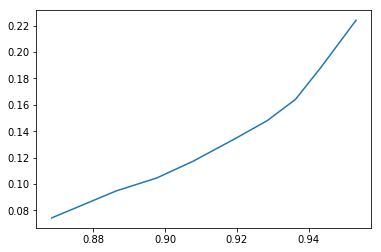

In [45]:
from matplotlib import pyplot as plt
plt.plot(sen_tpr,fnr)
plt.show()